In [30]:
pip install -U osmnx networkx matplotlib geopy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sklearn
print(sklearn.__version__)


1.5.2


Ruta 1: Casa -> Externado a pie


D:\program files\Python\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Ruta encontrada: [5592924427, 2583212997, 822045698, 7371540520, 265804310, 9718811227, 9718811226, 9718811225, 9718811229, 9721035593, 9718811233, 9718811246, 9718811248, 10273837513, 265297234, 10273784507, 9425304566, 9425304573, 5686229949, 5483755025, 9425304580, 9424420650, 10260512860, 264377450, 10260512838, 10260512867, 10288079103, 10288079102, 10288079101, 10288079100, 10288079099, 265804446, 265804447, 10288079094, 265804449, 265804551, 265804461, 6683319430, 6683319433, 5146483571, 6439885781, 5098699633, 265804479]


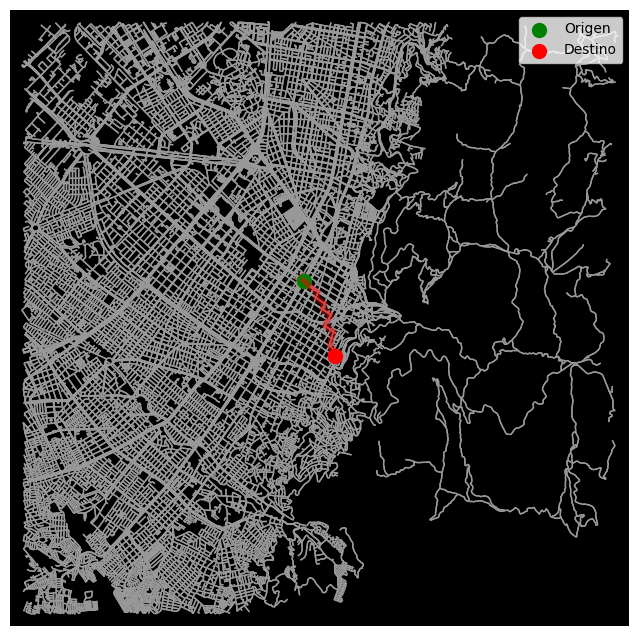

Ruta 2: Externado -> Ibero en carro


D:\program files\Python\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Ruta encontrada: [5098699633, 265804564, 265804573, 265804463, 265804587, 265804584, 265804454, 265804583, 265804442, 265804440, 265297194, 265297188, 265804590, 292659126, 8510301538, 4893039055, 954674886, 265804419, 265804414, 954674810, 265804408, 1031338278, 261746727, 264377366, 261673516, 261673518, 3545979512, 310660754, 3889256992, 455338148, 6361535176, 261138377, 455338136, 5406620274, 5406620273, 3283295932, 7996368344, 4981936922, 2045403998, 3188427500, 5087416436, 3982927538, 3188427503, 3982927536, 5087463880, 3188427509, 2045404009, 3850575957, 3191672981, 3191672982, 3191672984, 3192612243, 3191672986, 7796037811, 3948925063, 5385065225, 5385065224, 5385065223, 3938608094, 3938608091, 3938608088, 3937066545, 3938608087, 3938608086, 3938608095, 3938608097, 3938608085, 3938608084, 3937066544, 5105782060, 1038784839, 312655578, 432495018]


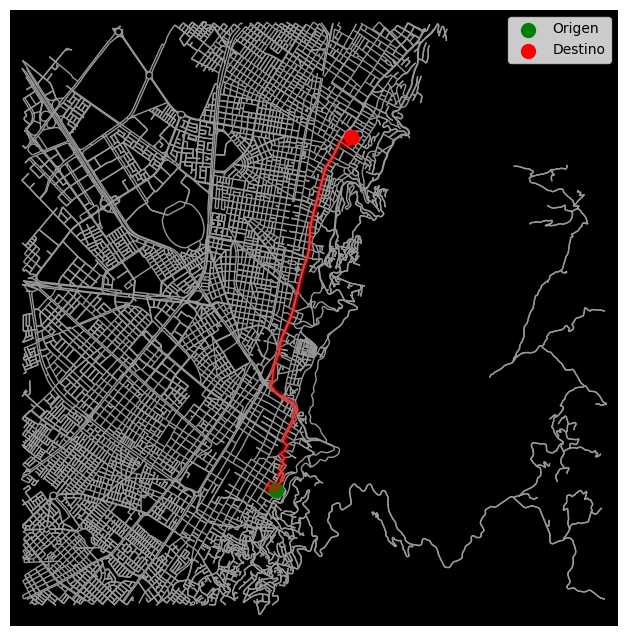

Ruta 3: Ibero -> Casa en carro


D:\program files\Python\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


Ruta encontrada: [432495018, 9338946813, 309299060, 5105816176, 253762212, 312655447, 253762102, 265500146, 254530338, 283342312, 263369023, 2498505034, 253762199, 263544186, 265491415, 265849876, 264786515, 264417540, 263369099, 7996375402, 265852733, 253762044, 263732334, 263732357, 263732455, 263776604, 263776685, 3191652247, 253762095, 263776785, 264153825, 264153877, 263776846, 263776839, 264153927, 264153946, 5087416469, 253761985, 3880667409, 5384764649, 5406620276, 5384764669, 261138466, 261138472, 8037818714, 262567769, 261138489, 262567569]


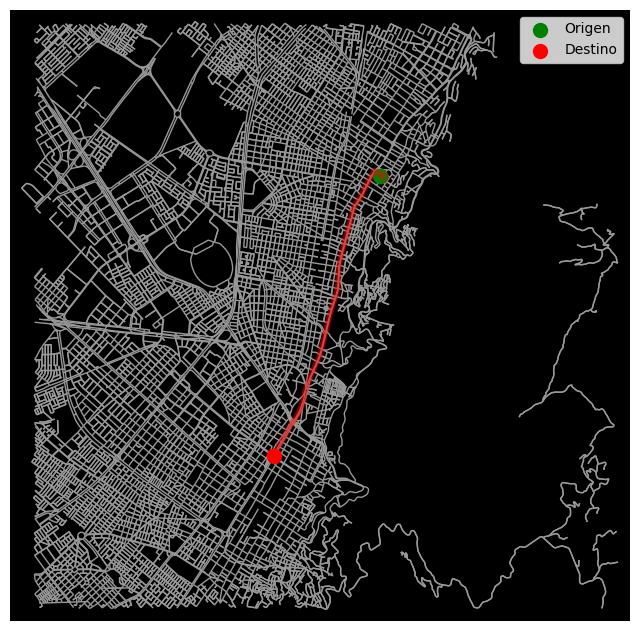

In [31]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import sklearn
from geopy.distance import geodesic

# Configuración actualizada de OSMnx
ox.settings.use_cache = True
ox.settings.log_console = True

def cargar_grafo(transit_mode, punto_A, punto_B, buffer_km=1):
    """
    Carga el grafo del sistema de transporte basado en OpenStreetMap dentro de un buffer alrededor de los puntos A y B.
    
    :param transit_mode: Tipo de transporte (e.g., 'walk', 'drive', 'all')
    :param punto_A: Tupla (latitud, longitud) del punto A
    :param punto_B: Tupla (latitud, longitud) del punto B
    :param buffer_km: Radio del buffer en kilómetros
    :return: Grafo de NetworkX
    """
    # Calcular el punto central entre A y B
    lat_A, lon_A = punto_A
    lat_B, lon_B = punto_B
    centro_lat = (lat_A + lat_B) / 2
    centro_lon = (lon_A + lon_B) / 2
    

    
    # Convertir el buffer de km a metros
    buffer_m = buffer_km * 1000
    
    # Obtener el grafo desde el punto central con el buffer en metros
    G = ox.graph_from_point((centro_lat, centro_lon), dist=buffer_m, network_type=transit_mode, simplify=True)

    
    return G

def encontrar_nodos_cercanos(G, punto):
    """
    Encuentra el nodo más cercano en el grafo para un punto dado.
    
    :param G: Grafo de NetworkX
    :param punto: Tupla (latitud, longitud)
    :return: Nodo más cercano
    """
    return ox.distance.nearest_nodes(G, punto[1], punto[0])

def definir_reglas(G, transit_mode='walk'):
    """
    Define reglas lógicas para determinar el peso de las aristas.
    Por ejemplo, podemos priorizar rutas más rápidas.
    
    :param G: Grafo de NetworkX
    :param transit_mode: Tipo de transporte para ajustar la velocidad promedio
    :return: Grafo con pesos actualizados
    """
    # Definir velocidad promedio según el modo de transporte
    if transit_mode == 'walk':
        velocidad_promedio = 5  # km/h para caminar
    elif transit_mode == 'drive':
        velocidad_promedio = 40  # km/h para conducir
    else:
        velocidad_promedio = 10  # Valor por defecto 
    
    for u, v, data in G.edges(data=True):
        # Supongamos que cada arista tiene una longitud en metros
        length = data.get('length', 1)
        # Definir un peso basado en el tiempo estimado
        tiempo_estimado = (length / 1000) / velocidad_promedio * 60  # en minutos
        data['weight'] = tiempo_estimado
    return G

def buscar_mejor_ruta(G, origen, destino):
    """
    Busca la mejor ruta entre origen y destino utilizando Dijkstra.
    
    :param G: Grafo de NetworkX con pesos definidos
    :param origen: Nodo de origen
    :param destino: Nodo de destino
    :return: Lista de nodos que conforman la ruta
    """
    try:
        ruta = nx.dijkstra_path(G, origen, destino, weight='weight')
        return ruta
    except nx.NetworkXNoPath:
        print("No se encontró una ruta entre los puntos especificados.")
        return None

def visualizar_ruta(G, ruta, area, punto_A, punto_B):
    """
    Visualiza la ruta en un mapa con marcadores para origen y destino y aplica zoom.
    
    :param G: Grafo de NetworkX
    :param ruta: Lista de nodos que conforman la ruta
    :param area: Área geográfica de interés
    :param punto_A: Coordenadas del punto A
    :param punto_B: Coordenadas del punto B
    :param zoom: Radio en metros para el zoom alrededor de la ruta
    """
    # Obtener las coordenadas de la ruta
    ruta_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in ruta]
    latitudes, longitudes = zip(*ruta_coords)
    
    # Calcular el centro de la ruta
    centro_lat = (max(latitudes) + min(latitudes)) / 2
    centro_lon = (max(longitudes) + min(longitudes)) / 2
    
    # Crear la gráfica
    fig, ax = ox.plot_graph_route(G, ruta, route_linewidth=4, node_size=0, bgcolor='k', show=False, close=False)
    
    # Añadir marcadores de origen y destino
    ax.scatter(punto_A[1], punto_A[0], c='green', s=100, label='Origen')
    ax.scatter(punto_B[1], punto_B[0], c='red', s=100, label='Destino')
    
    # Aplicar zoom
    # ax.set_xlim(centro_lon - 0.001, centro_lon + 0.001)  
    # ax.set_ylim(centro_lat - 0.001, centro_lat + 0.001)
    
    ax.legend()
    plt.show()

def procesar_ruta(nombre_ruta, modo_transito, punto_inicio, punto_final, buffer_km=5):
    """
    Procesa una ruta específica: carga el grafo, define reglas, encuentra nodos cercanos,
    busca la mejor ruta y la visualiza si se encuentra.

    Args:
        nombre_ruta (str): Descripción de la ruta.
        modo_transito (str): Modo de tránsito ('walk', 'drive', etc.).
        punto_inicio (tuple): Coordenadas (lat, lon) del punto de inicio.
        punto_final (tuple): Coordenadas (lat, lon) del punto final.
        buffer_km (int, opcional): Radio en kilómetros para cargar el grafo. Por defecto es 5.
    """
    print("=" * 100)
    print(nombre_ruta)
    
    # Cargar y configurar el grafo con puntos de inicio y fin separados
    grafo = cargar_grafo(modo_transito, punto_inicio, punto_final, buffer_km=buffer_km)
    grafo = definir_reglas(grafo, transit_mode=modo_transito)
    
    # Encontrar nodos cercanos al inicio y al final
    origen = encontrar_nodos_cercanos(grafo, punto_inicio)
    destino = encontrar_nodos_cercanos(grafo, punto_final)
    
    # Buscar la mejor ruta
    ruta = buscar_mejor_ruta(grafo, origen, destino)
    
    # Visualizar la ruta si se encuentra
    if ruta:
        print("Ruta encontrada:", ruta)
        visualizar_ruta(grafo, ruta, nombre_ruta, punto_inicio, punto_final)
    else:
        print("No se encontró una ruta para:", nombre_ruta)


def main():
    # Coordenadas de los puntos
    punto_casa = (4.606979, -74.073794)           # Mi casa
    punto_externado = (4.595600, -74.069014)      # Universidad Externado de Colombia
    punto_ibero = (4.649893, -74.057384)          # Corporación Universitaria Iberoamericana
    
    # Definir las rutas a procesar
    rutas = [
        {
            "nombre": "Ruta 1: Casa -> Externado a pie",
            "modo_transito": "walk",
            "inicio": punto_casa,
            "fin": punto_externado
        },
        {
            "nombre": "Ruta 2: Externado -> Ibero en carro",
            "modo_transito": "drive",
            "inicio": punto_externado,
            "fin": punto_ibero
        },
        {
            "nombre": "Ruta 3: Ibero -> Casa en carro",
            "modo_transito": "drive",
            "inicio": punto_ibero,
            "fin": punto_casa
        }
    ]
    
    # Procesar cada ruta
    for ruta in rutas:
        procesar_ruta(
            nombre_ruta=ruta["nombre"],
            modo_transito=ruta["modo_transito"],
            punto_inicio=ruta["inicio"],
            punto_final=ruta["fin"]
        )


if __name__ == "__main__":
    main()


